<a href="https://colab.research.google.com/github/LaviJ/Cryptocurrency-Analysis/blob/hourly-ML2/Machine%20Learning/model-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Forcasting Cryptocurrency
# Data Analysis and Visualization
# Group 7

# TensorFlow model training routine

import os
import datetime
import pymongo
from pymongo import MongoClient
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Adapted/Refactored from Tensorflow Routines for Time Series Data
# https://www.tensorflow.org/tutorials/structured_data/time_series
'''Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
Yuan Yu, and Xiaoqiang Zheng.'''

# TensorFlow: Large-scale machine learning on heterogeneous systems,
# 2015. Software available from tensorflow.org.


'Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,\nZhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,\nJeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,\nAndrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,\nLukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,\nRajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,\nBenoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,\nVincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,\nOriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,\nYuan Yu, and Xiaoqiang Zheng.'

In [2]:
# Coin ticker symbol to analyze
symbol = 'BTC'

# Initialize some graphic parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = True

# Extract, transform, and load the input data

# Pull data from mongodb
path = tf.keras.utils.get_file(
  origin='https://raw.githubusercontent.com/LaviJ/Cryptocurrency-Analysis/main/Data/Hourly/hourly_'+symbol+'.csv',
  fname='hourly_'+symbol+'.csv')
csv_path, _ = os.path.splitext(path)

# Read data into dataframe
df = pd.read_csv(csv_path+".csv")


# Drop some columns
df = df.drop('conversionType', axis=1)
df = df.drop('conversionSymbol', axis=1)
df = df.drop('volumeto', axis=1)
df = df.drop('volumefrom', axis=1)
#df = df.drop('_id', axis=1)
#df = df.drop('index', axis=1)
#df = df.drop('Symbol', axis=1)
df = df.drop('open', axis=1)
df = df.drop('high', axis=1)
df = df.drop('low', axis=1)

# Drop row with any zero
df = df[(df != 0).all(1)]

# Drop last row
df = df[:-1]
df = df[:20000]
# Move the timestamps into an array
date_time =[0]
date_time = df.pop('time')



C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df

,close
0,43727.60
1,43734.62
2,43702.67
3,43649.09
4,43527.81
...,...
19995,8366.89
19996,8357.69
19997,8382.89
19998,8360.78


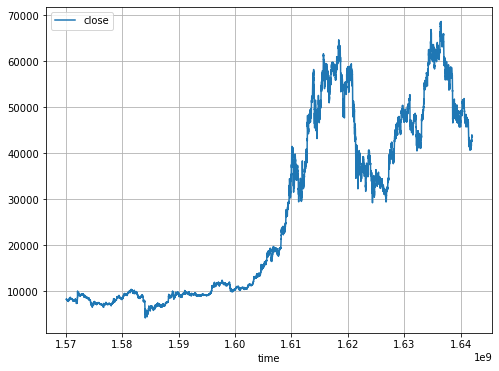

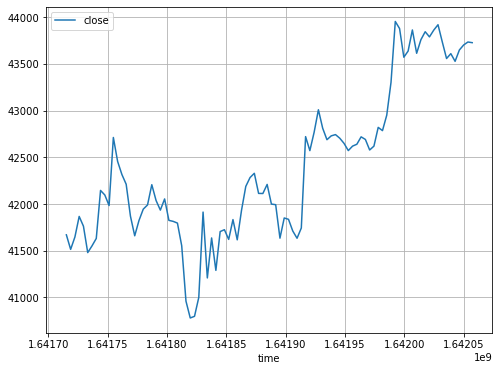

In [4]:
# Display the input data: since BTC genesis and last 96 hours
plot_cols = ['close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:96]
plot_features.index = date_time[:96]
_ = plot_features.plot(subplots=True)

In [5]:
# Show the statistical description

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
close,20000.0,27135.578864,19670.659076,4240.69,9222.5575,17902.73,46858.745,68624.18


In [6]:
# Define sinusoid wave periods

timestamp_s = date_time 

# define a day, although we won't use the daily curve for crypto
day = 24*60*60

# the weekend and business week happen on a weekly basis
week = 7*day

# paychecks are signed every two weeks
biweek = 2*week

# The holiday season is annual
year = (365.2425)*day

# Quarterly earnings reports happen quarterly
quarter = (365.2425/4)*day

# Load the waves into the dataframe
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Quarter sin'] = np.sin(timestamp_s * (2 * np.pi / quarter))
df['Quarter cos'] = np.cos(timestamp_s * (2 * np.pi / quarter))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

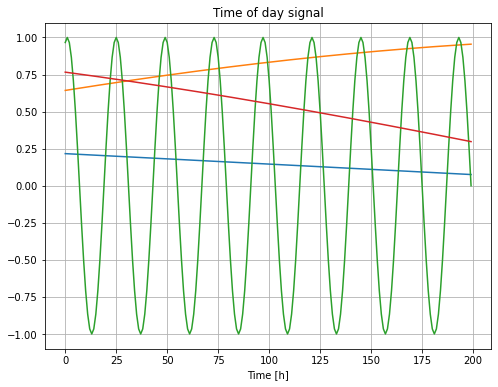

In [7]:
# Display the weekly signal

plt.plot(np.array(df['Year sin'])[:200])
plt.plot(np.array(df['Quarter cos'])[:200])
plt.plot(np.array(df['Day sin'])[:200])
plt.plot(np.array(df['Quarter sin'])[:200])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [8]:
df

,close,Day sin,Day cos,Quarter sin,Quarter cos,Year sin,Year cos
0,43727.60,9.659258e-01,-2.588190e-01,0.766028,0.642807,0.216433,0.976297
1,43734.62,1.000000e+00,3.288925e-12,0.764182,0.645000,0.215734,0.976452
2,43702.67,9.659258e-01,2.588190e-01,0.762330,0.647189,0.215034,0.976607
3,43649.09,8.660254e-01,5.000000e-01,0.760471,0.649372,0.214334,0.976761
4,43527.81,7.071068e-01,7.071068e-01,0.758606,0.651550,0.213633,0.976914
...,...,...,...,...,...,...,...
19995,8366.89,8.660254e-01,5.000000e-01,0.092918,0.995674,-0.999729,0.023261
19996,8357.69,7.071068e-01,7.071068e-01,0.090063,0.995936,-0.999746,0.022544
19997,8382.89,5.000000e-01,8.660254e-01,0.087208,0.996190,-0.999762,0.021828
19998,8360.78,2.588190e-01,9.659258e-01,0.084351,0.996436,-0.999777,0.021111


In [9]:
# Use a (70%, 20%, 10%) split for the training, validation, and test sets. 
# Note the data is not being randomly shuffled before splitting.

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
# Normalize training datasets

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

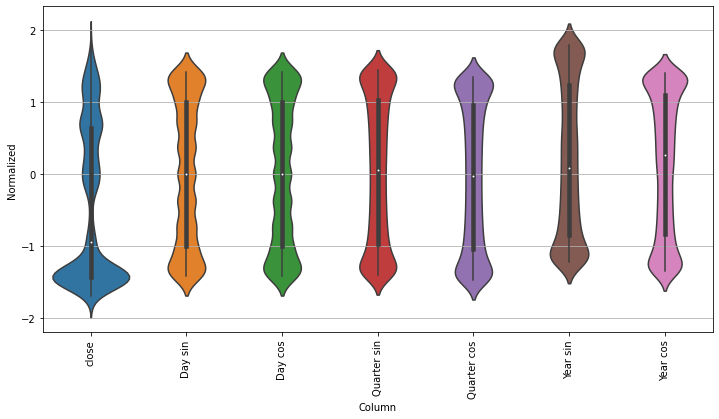

In [11]:
# Show distribution

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [12]:
# Define TensorFlow windows

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [13]:
# Create slices

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [14]:
# Define a method to generate mean error plots

def plot(self, model=None, plot_col='close', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [15]:
#  This make_dataset method will take a time series DataFrame and convert
#  it to a tf.data.Dataset of (input_window, label_window) pairs using the 
#  tf.keras.utils.timeseries_dataset_from_array function

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

# The WindowGenerator object holds training, validation, and test data.
# accessing them as tf.data.Datasets using the make_dataset method as
# defined earlier
WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
# Define the training procedure

MAX_EPOCHS = 11
BATCH_SIZE = 1024
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  opt = tf.keras.optimizers.Adam(learning_rate=0.1)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

  with tf.device('/device:GPU:1'):
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],batch_size=BATCH_SIZE)
  return history

#### RNN: Recurrent Neural Networks

Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): None

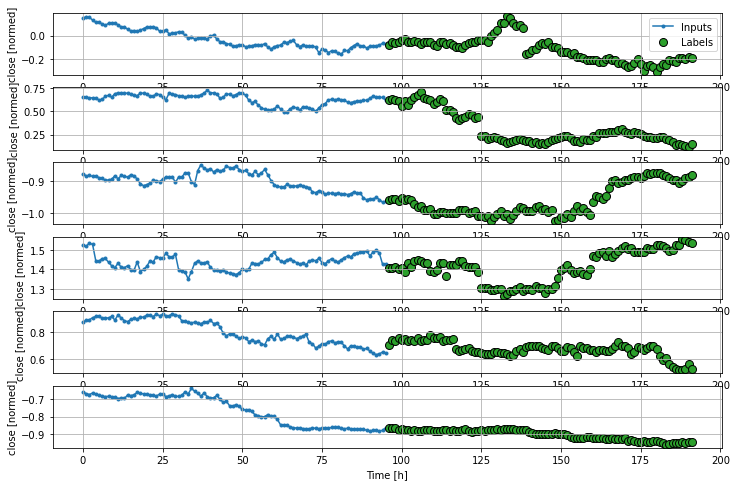

In [17]:
# Create a model to learn to predict 96 hours into the future, given 96 hours
# of the past.

OUT_STEPS = 96
multi_window = WindowGenerator(input_width=96,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Epoch 1/11
432/432 [==============================] - 9s 18ms/step - loss: 0.0248 - mean_absolute_error: 0.0785 - val_loss: 0.0543 - val_mean_absolute_error: 0.1697
Epoch 2/11
432/432 [==============================] - 7s 16ms/step - loss: 0.0040 - mean_absolute_error: 0.0439 - val_loss: 0.0704 - val_mean_absolute_error: 0.1943
Epoch 3/11
432/432 [==============================] - 7s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0401 - val_loss: 0.0691 - val_mean_absolute_error: 0.1701
Epoch 4/11
432/432 [==============================] - 7s 15ms/step - loss: 0.0700 - mean_absolute_error: 0.1214 - val_loss: 1.2292 - val_mean_absolute_error: 0.9049
Epoch 5/11
432/432 [==============================] - 7s 15ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/11
432/432 [==============================] - 7s 15ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan


INFO:tensorflow:Assets written to: BTClstm_model\assets


INFO:tensorflow:Assets written to: BTClstm_model\assets


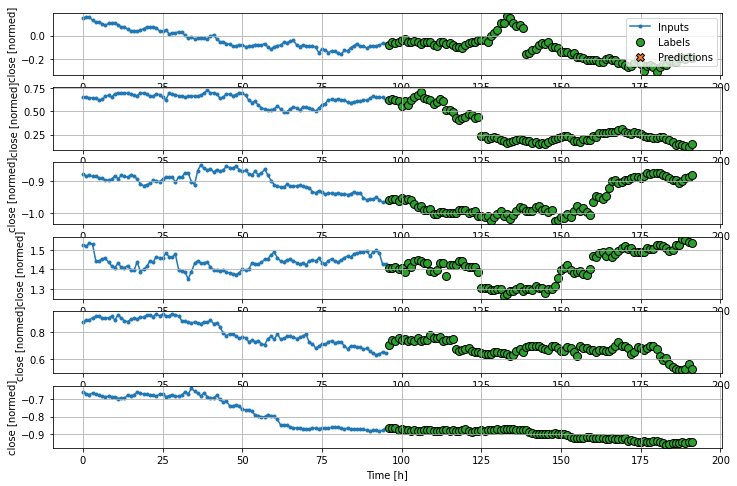

In [18]:
# Calculate the Recurrent model

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
""
history = compile_and_fit(multi_lstm_model, multi_window)
multi_window.plot(multi_lstm_model)
multi_lstm_model.save(symbol+"lstm_model")

In [20]:
# Long Short-Term Memory Bi-Directional NN
   
# Calculate the Bidirectional model
bidir = tf.keras.Sequential()
bidir.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM((256), return_sequences=True)))
bidir.add(tf.keras.layers.Dropout(rate=.5))
bidir.add(tf.keras.layers.Dense(units=7, activation='sigmoid'))

history = compile_and_fit(bidir, multi_window)
multi_window.plot(bidir)
bidir.save(symbol+"bidir_model")

Epoch 1/11
213/432 [=============>................] - ETA: 25s - loss: nan - mean_absolute_error: nan

KeyboardInterrupt: ignored

In [ ]:
# Define the Autoregressive RNN LSTM model
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
 # A warmup method to initialize internal state based on the inputs.
 
 def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
# Display the tesor shape
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
# Define the feedback method

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
# Print the output shape

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
# Train the Autoregressive RNN feedback model 
history = compile_and_fit(feedback_model, multi_window)
multi_window.plot(feedback_model)

In [ ]:
# Save the feedback_model

feedback_model.save(symbol+'feedback_model')